In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets.cityscapes import setupDatasetsAndLoaders

In [2]:
# CUDA check
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


In [3]:
print(torch.__version__)

1.4.0


### Datasets and Dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image name: ('ulm_000032_000019_leftImg8bit',)
image tensor size: torch.Size([1, 3, 1024, 2048])
annotated output tensor size: torch.Size([1, 1024, 2048])


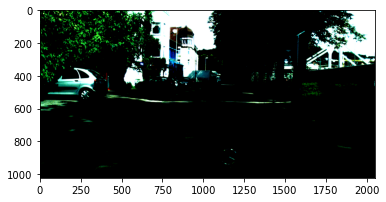

In [4]:
train_set, val_set, test_set, train_loader, val_loader, test_loader = setupDatasetsAndLoaders('./data', batch_size=1)

for sample in train_loader:
    imgSeq, annotatedOutput, imgName = sample

    print(f'image name: {imgName}')
    print(f'image tensor size: {imgSeq[-1].shape}')
    print(f'annotated output tensor size: {annotatedOutput.shape}')

    plt.imshow(imgSeq[-1][0].permute(1, 2, 0))
#     print(annotatedOutput[0,200:400,0:200])
#     plt.imshow(annotatedOutput[0])
    break

### Model

In [5]:
# Define AutoEncoder Model for MNIST
class MNIST_Autoencoder(nn.Module):

    def __init__(self, num_classes=20):
        
        # Init from nn.Module
        super().__init__()
        
        # Encoder part will be a simple sequence of Conv2d+ReLU.
        self.encoder = nn.Sequential(nn.Conv2d(3, 16, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(64, 128, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 256, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(256, 256, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(256, 512, 3),
                                     nn.ReLU(),
                                     nn.Conv2d(512, num_classes, 1))
        
        
        # Decoder part will be a simple sequence of TransposeConv2d+ReLU.
        # Finish with Sigmoid
        self.decoder = nn.Sequential(nn.ConvTranspose2d(num_classes, num_classes, 3),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU())
        

    def forward(self,x):
        
        # Forward is encoder into decoder
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
#         print(x.shape)
        return x

### Train

In [6]:
# Initialize MNIST Autoencoder
torch.manual_seed(10)
model = MNIST_Autoencoder().to(device)

In [7]:
for sample in train_loader:
    imgSeq, annotatedOutput, imgName = sample
    model(imgSeq[0].to(device))
    break

In [8]:
# Defining Parameters
# - MSE Loss, which will be our reconstruction loss for now
# - Adam as optimizer
# - 20 Epochs
# - 128 as batch size
num_epochs = 1
batch_size = 128
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(),weight_decay = 1e-5)

In [9]:
# Train
outputs_list = []
loss_list = []
for epoch in range(num_epochs):
    for data in tqdm(train_loader):
        imgSeq, annotatedOutput, imgName = data
        
        # Send data to device
        img = Variable(imgSeq[-1]).to(device)
        
        # Forward pass
        output = model(img)
        annotatedOutput = annotatedOutput.to(device).long()
#         print(f"output:{output}")
#         print(f"output shape:{output.size()}")
#         print(f"annotatedOutput:{annotatedOutput}")
#         print(f"annotated output shape:{annotatedOutput.size()}")
#         break
#         break
        loss = loss_fn(output, annotatedOutput)
#         print(f"okay here is the iou table{iou_pytorch(output,annotatedOutput)}")
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    outputs_list.append((epoch, img, output),)
    loss_list.append(loss.item())

100%|██████████| 66/66 [00:35<00:00,  1.85it/s]

epoch 1/1, loss 2.2072


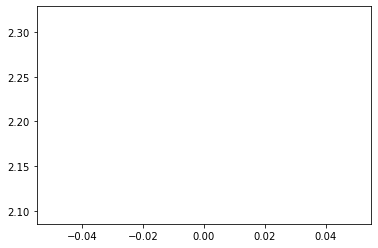

In [10]:
# Display loss
plt.figure()
plt.plot(loss_list)
plt.show()

(20, 1024, 2048)


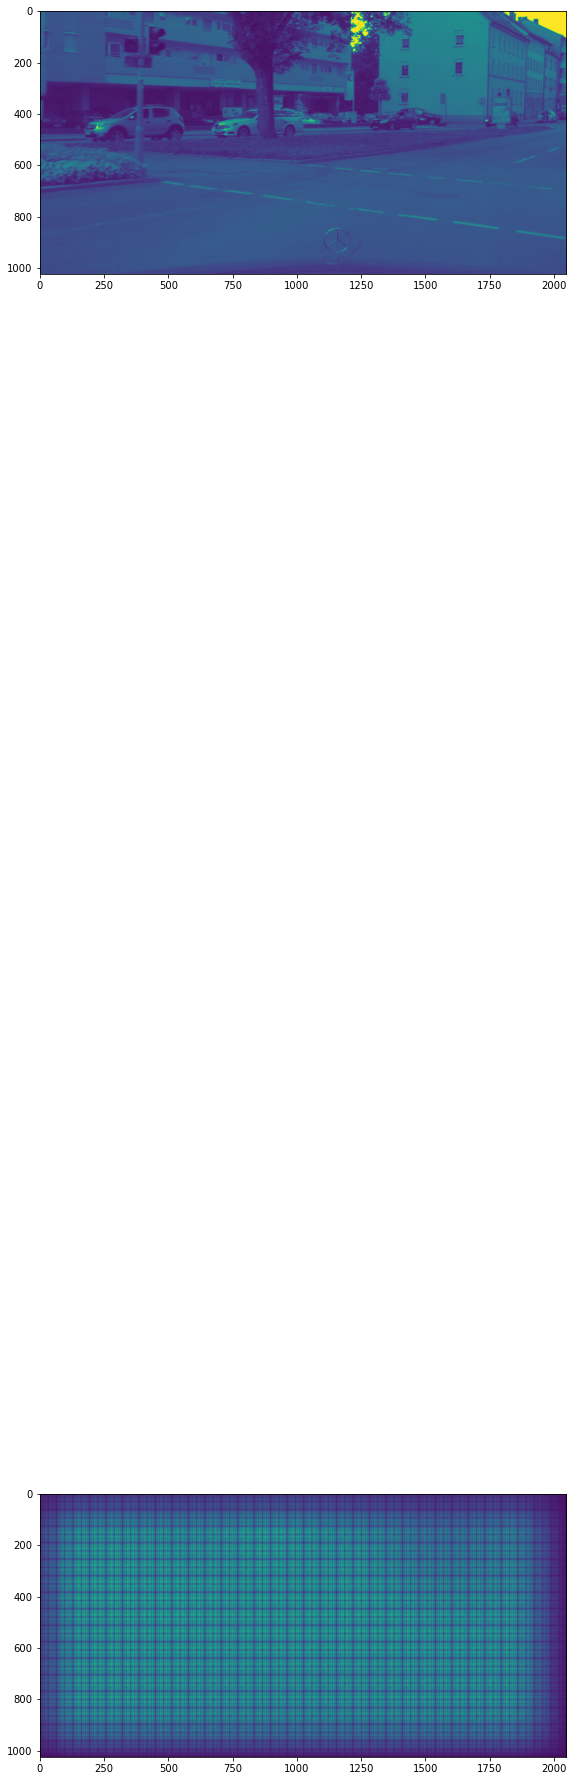

In [11]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize = (100, 50))
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        print(item.shape)
        plt.imshow(item[0,:,:])

In [23]:
# IOU function
SMOOTH = 1e-6

# output shape: (1,20,1028,2056), label shape: (20,1028,2056)
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor): 
    iou_class={} 
    num_class = list(outputs.size())[1]
    for i in range(20): 
        # get the most likely class out of the probabilities calculated for each class
        output_class_most_likely, indices =torch.max(outputs,dim=1)
        mask_size = list(labels.size())[1:]
        boolean_mask = torch.ones(mask_size, dtype=torch.float64, device = device).bool()
        # create a mask for each class
        mask = torch.ones(mask_size, dtype=torch.float64, device = device)*i

        select_label_class = torch.eq(mask, labels).to(device)
        select_predicted_class = torch.eq(mask, indices).to(device)
        intersection = (select_label_class & select_predicted_class)
        # union is number of predicted samples and number of labelled samples for each class - intersection
        union_sum = select_predicted_class.sum()+select_label_class.sum() - intersection.sum()  
        
        iou = (intersection.sum() + SMOOTH) / (union_sum + SMOOTH) 
        iou_class[i]=iou
    return sum(list(iou_class.values()))/num_class 

In [24]:
test_list=[]
count=0
for data in tqdm(test_loader):
    if count==1:
        break
    model.eval()
    with torch.no_grad():
        imgSeq, annotatedOutput, imgName = data

        # Send data to device
        img = Variable(imgSeq[-1]).to(device)

        # Forward pass
        output = model(img)

        annotatedOutput = annotatedOutput.to(device).long()
        loss = loss_fn(output, annotatedOutput)
        iou_dict = iou_pytorch(output, annotatedOutput)
        test_list.append((img, output,iou_dict),)
        count+=1

  7%|▋         | 1/15 [00:00<00:08,  1.73it/s]

{0: tensor(0.3053, device='cuda:0'), 1: tensor(5.8003e-12, device='cuda:0'), 2: tensor(5.7087e-12, device='cuda:0'), 3: tensor(1., device='cuda:0'), 4: tensor(5.3589e-12, device='cuda:0'), 5: tensor(1.2418e-10, device='cuda:0'), 6: tensor(1.5175e-09, device='cuda:0'), 7: tensor(6.4103e-10, device='cuda:0'), 8: tensor(0.0835, device='cuda:0'), 9: tensor(3.8275e-11, device='cuda:0'), 10: tensor(2.1880e-11, device='cuda:0'), 11: tensor(1., device='cuda:0'), 12: tensor(1., device='cuda:0'), 13: tensor(2.4900e-10, device='cuda:0'), 14: tensor(1., device='cuda:0'), 15: tensor(2.6439e-12, device='cuda:0'), 16: tensor(1., device='cuda:0'), 17: tensor(1., device='cuda:0'), 18: tensor(1., device='cuda:0'), 19: tensor(1., device='cuda:0')}


  7%|▋         | 1/15 [00:01<00:14,  1.03s/it]


0.41943964


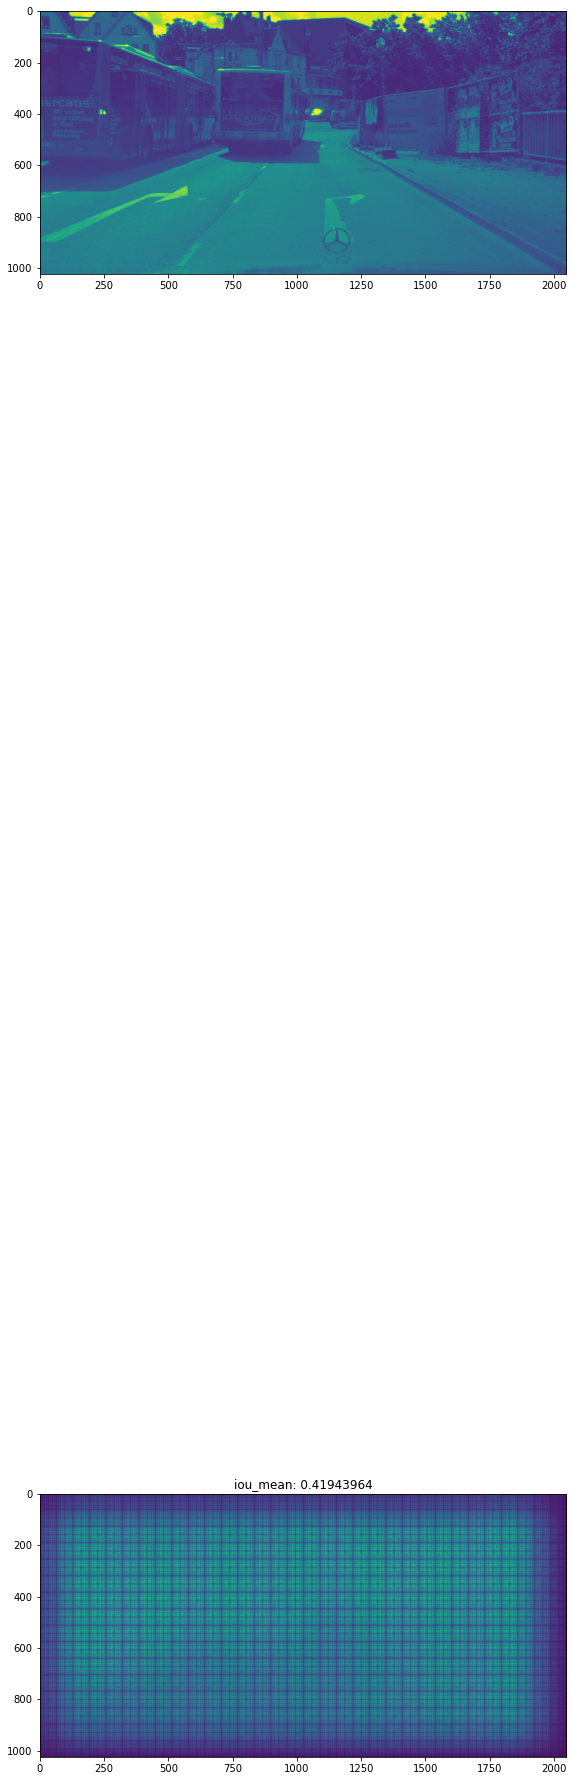

In [20]:
for j in range(1):
    ax = plt.figure(figsize = (100, 50))
    imgs = test_list[j][0].cpu().detach().numpy()
    recon = test_list[j][1].cpu().detach().numpy()
    iou_mean = test_list[j][2].cpu().detach().numpy()
    print(iou_mean)
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i >= 9: break
        ax= plt.subplot(2, 9, 9+i+1)
        ax.set_title('iou_mean: '+str(iou_mean))
        plt.imshow(item[0,:,:])